In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from choropleth_functions import *

In [4]:
dates = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']
dates2 = ['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']

# plotty_plots(kw, dates, renderer = 'png', rows = 2, cols = 3, savefig = False):
plotty_plots('WINE', dates2, rows = 4, cols = 3, savefig=False, renderer='firefox')

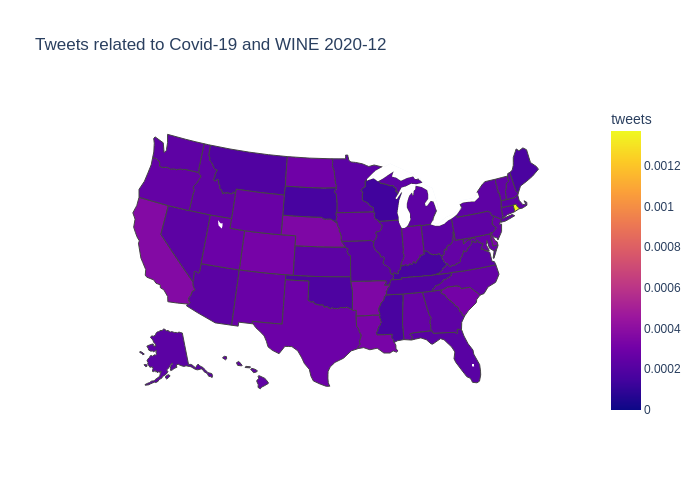

In [62]:
plotty('WINE', '2020-12')
#plotty_w('WINE', '1')

In [7]:
build_dataframe('ALCOHOL', ['2020-09'])

,State,Date,Count
0,AK,2020-09,0.000947
1,AL,2020-09,0.001613
2,AR,2020-09,0.001244
3,AZ,2020-09,0.001174
4,CA,2020-09,0.000855
5,CO,2020-09,0.001145
6,CT,2020-09,0.000843
7,DC,2020-09,0.000463
8,DE,2020-09,0.000619
9,FL,2020-09,0.001183
